### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

import matplotlib.pyplot as plt
%matplotlib widget

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

### 0 - Setting the random state

In [2]:
random_state = min(332078,328202)

In [3]:
np.random.seed(random_state)

## 1 - Loading and Preparing the Data

### 1.1 - Import the dataset

In [ ]:
# Import csv
file_name = 'cla4lsp_customers.csv'
df_tot = pd.read_csv(file_name, sep='\t')

### 1.2 - Spit dataset

In [ ]:
from sklearn.model_selection import train_test_split

fraction = 2/3
# Split the dataset
workdf, not_workdf = train_test_split(df_tot, test_size=1 - fraction, random_state=random_state)

In [ ]:
# Save the dataframes
workdf.to_csv('working_dataset.csv')
not_workdf.to_csv('not_working_dataset.csv')

In [4]:
# Import the datasets
workdf = pd.read_csv('working_dataset.csv')
not_workdf = pd.read_csv('not_working_dataset.csv')

### 1.3 - Divide columns 

In [5]:
labels = ['NumDealsPurchases','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response','Complain','Recency']
features = ['Year_Birth','Education','Marital_Status','Income','Kidhome','Teenhome','Dt_Customer','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']
other_columns = [col for col in workdf.columns if col not in (labels + features)]

In [6]:
# Drop unknown columns
workdf = workdf.drop(other_columns, axis=1)

### 1.4 - Remove a random feature

In [7]:
purchasing_habits = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

In [8]:
# Removing random feature
random_pick = random.choice(purchasing_habits)
workdf = workdf.drop(random_pick, axis=1)
features.remove(random_pick)

### 1.5 - Data cleaning

In [9]:
print(f' NaN elements from working set:\n{workdf.isna().sum()}')
print(f' \nNaN elements from NON working set:\n{not_workdf.isna().sum()}')

 NaN elements from working set:
Year_Birth              0
Education               0
Marital_Status          0
Income                 16
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Response                0
dtype: int64
 
NaN elements from NON working set:
Unnamed: 0             0
ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 8
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines          

#### 1.5.1 - Drop columns

In [10]:
workdf.dropna(inplace=True)
not_workdf.dropna(inplace=True)

#### 1.5.2- Fill NaN values

In [ ]:
# Rows with NaN values
nan_mask = workdf['Income'].isna()
workdf[nan_mask]

In [ ]:
# Group the incomes with respect to education level and marital status
grouped_df = workdf.groupby(['Education','Marital_Status'])['Income'].mean()

In [ ]:
# Expected output
exp_out = []
for i in range(len(workdf[nan_mask])):
    exp_out.append(grouped_df[( workdf[nan_mask]['Education'].iloc[i] , workdf[nan_mask]['Marital_Status'].iloc[i] )])
exp_out

In [ ]:
# Extract row indices with NaN values
id = [workdf[nan_mask].index][0]

In [ ]:
# Fill the NaN values
for i in workdf.index:
    if workdf['Income'].isna:
        workdf.loc[i,'Income'] = grouped_df[( workdf.loc[i,'Education'] , workdf.loc[i,'Marital_Status'] )]

In [ ]:
# Check whether the newly substituted numbers are equal to the expected numbers
workdf.loc[id,'Income'] == exp_out

## 2 - Encoding of Categorical Data

In [11]:
# Education levels
workdf['Education'].value_counts()

Education
Graduation    770
PhD           325
Master        226
2n Cycle      123
Basic          33
Name: count, dtype: int64

In [12]:
# Scale the education feature with respect to the education level
education_dict = {'Basic':0,
                  '2n Cycle':1, 
                  'Graduation':2, 
                  'Master':3,
                  'PhD':4}
workdf['Education level'] = workdf['Education'].replace(education_dict)
workdf = workdf.drop(columns='Education')

In [13]:
# Marital status
workdf['Marital_Status'].value_counts()

Marital_Status
Married     567
Together    390
Single      317
Divorced    143
Widow        54
Alone         3
Absurd        2
YOLO          1
Name: count, dtype: int64

In [14]:
# Assign a boolean value based on marital status (1:Together status, 0:Single status)
m_status_dict = {'Married': 1, 
                 'Together': 1, 
                 'Single': 0, 
                 'Divorced': 0, 
                 'Widow': 0, 
                 'Alone': 0, 
                 'Absurd': 0, 
                 'YOLO': 0}
workdf['InRelation'] = workdf['Marital_Status'].replace(m_status_dict)
workdf = workdf.drop(columns='Marital_Status')

In [15]:
# Change year of the birth with age
workdf['Age'] = 2023 - workdf['Year_Birth']
workdf = workdf.drop(columns='Year_Birth')

In [16]:
# Drop Dt_Customer column
workdf = workdf.drop(columns='Dt_Customer')

In [17]:
# Combine Kidhome and Teenhome to avoid confusion
'''''
workdf['Childhome'] = workdf['Kidhome'] + workdf['Teenhome']
workdf = workdf.drop(columns='Kidhome')
workdf = workdf.drop(columns='Teenhome')
'''''
pass

In [18]:
# Update features list
features.extend(['InRelation', 'Age','Education level'])
features.remove('Education')
features.remove('Marital_Status')
features.remove('Year_Birth')
features.remove('Dt_Customer')

In [19]:
# Show some information of the dataset
workdf.describe()

,Income,Kidhome,Teenhome,Recency,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Education level,InRelation,Age
count,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,...,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000,1477.000000
mean,52197.784699,0.452268,0.507109,48.810427,25.949221,169.330399,38.074475,27.521327,42.989844,2.368314,...,0.065674,0.075152,0.073798,0.064997,0.010156,0.010833,0.148274,2.465132,0.647935,54.167231
std,26658.477243,0.542181,0.541737,29.020119,39.419597,227.352628,55.081350,41.503555,49.708124,1.982245,...,0.247795,0.263726,0.261531,0.246603,0.100297,0.103550,0.355491,0.995060,0.477776,12.167577
min,1730.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000
25%,34916.000000,0.000000,0.000000,24.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,45.000000
50%,51373.000000,0.000000,0.000000,49.000000,8.000000,68.000000,12.000000,8.000000,25.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,53.000000
75%,68655.000000,1.000000,1.000000,73.000000,32.000000,238.000000,50.000000,34.000000,54.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,64.000000
max,666666.000000,2.000000,2.000000,99.000000,199.000000,1725.000000,258.000000,262.000000,249.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,130.000000


From the description of the dataset, especially looking at the 75th percentile and the maximum value of the columns, we can see that the columns: 'Income' and 'Age' have some outliers.

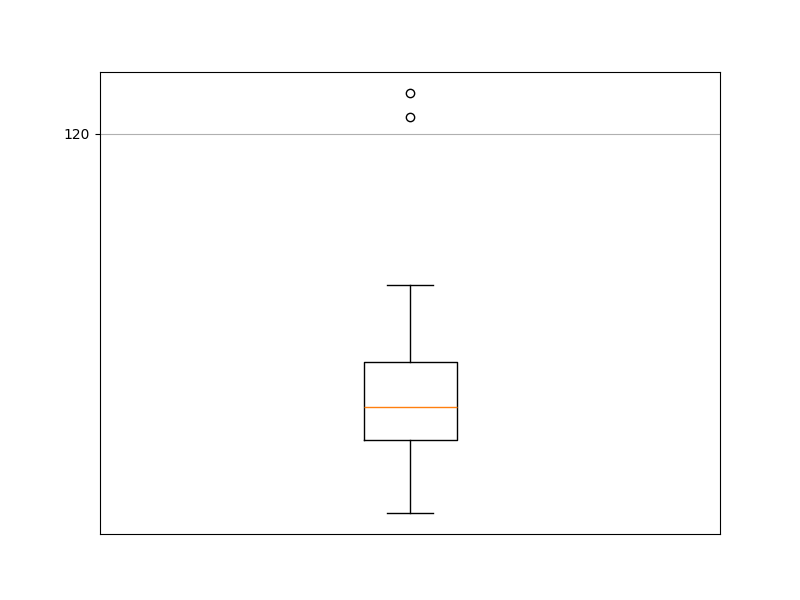

In [20]:
# Check the outlier from the 'Age' column
plt.figure(figsize=(8, 6))
plt.boxplot(workdf['Age'])
plt.yticks([120])
plt.xticks([])
plt.grid()
plt.show()

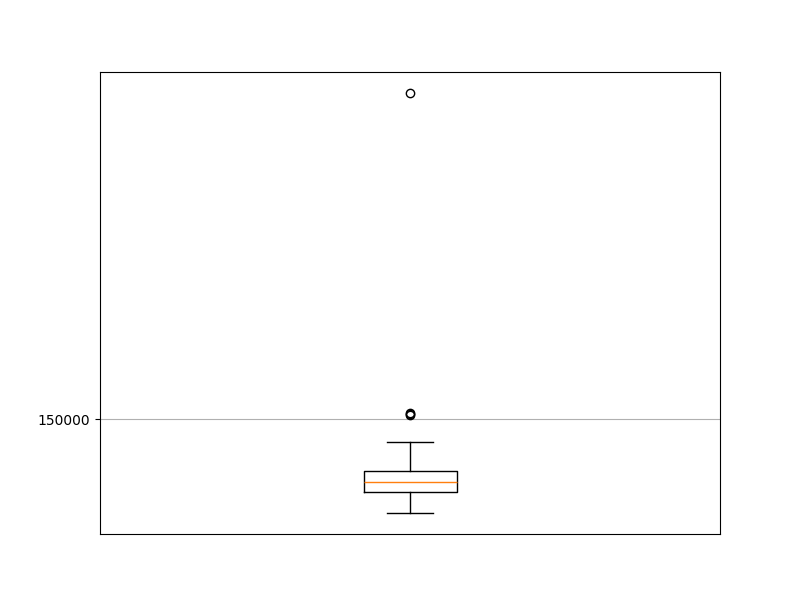

In [21]:
# Check the outlier from the 'Income' column
plt.figure(figsize=(8, 6))
plt.boxplot(workdf['Income'])
plt.yticks([150000])
plt.xticks([])
plt.grid()
plt.show()

In [22]:
# Exclude outlier
workdf = workdf[ (workdf['Income']<150000) ]
workdf = workdf[ (workdf['Age']<120) ]

In [23]:
# Define sub-df by selecting feature columns
Xworkdf = workdf[features]

## 3 - Preprocessing and full-PCA

### 3.1 - Standardize the features

In [24]:
# Create Xworkdf_std using the Standard scaler
Xworkdf_std = StandardScaler()
#fit
Xworkdf_std.fit(Xworkdf.values)
#transform
t_Xworkdf_std = Xworkdf_std.transform(Xworkdf.values)

# Create Xworksf_mm using the MinMax scaler
Xworksf_mm = MinMaxScaler()
#fit
Xworksf_mm.fit(Xworkdf.values)
#transform
t_Xworksf_mm = Xworksf_mm.transform(Xworkdf.values)

### 3.2 - First look at the variances (TODO)

In [25]:
variance1 = [np.var(Xworkdf.iloc[:,i]) for i in range(Xworkdf.shape[1])]
variance2 = [np.var(pd.DataFrame(t_Xworkdf_std).iloc[:,i]) for i in range(t_Xworkdf_std.shape[1])]
variance3 = [np.var(pd.DataFrame(t_Xworksf_mm).iloc[:,i]) for i in range(t_Xworksf_mm.shape[1])]

variance1 = np.var(Xworkdf.values)
variance2 = np.var(t_Xworkdf_std)
variance3 = np.var(t_Xworksf_mm)

max1 = np.max(Xworkdf)
max2 = np.max(t_Xworkdf_std)
max3 = np.max(t_Xworksf_mm)

min1 = np.min(Xworkdf)
min2 = np.min(t_Xworkdf_std)
min3 = np.min(t_Xworksf_mm)

mean1 = np.mean(Xworkdf)
mean2 = np.mean(t_Xworkdf_std)
mean3 = np.mean(t_Xworksf_mm)
# Print variances
print(f'\nVariance of each feature of non rescaled data:\n {variance1}')
print(f'\nVariance of each feature of standar-scaled data:\n {variance2}')
print(f'\nVariance of each feature of MinMax-scaled data:\n {variance3}')

# Print Max
print(f'\nMax of non rescaled data:\n {max1}')
print(f'\nMax of standar-scaled data:\n {max2}')
print(f'\nMax of MinMax-scaled data:\n {max3}')

# Print Min
print(f'\nMin of non rescaled data:\n {min1}')
print(f'\nMin of standar-scaled data:\n {min2}')
print(f'\nMin of MinMax-scaled data:\n {min3}')

# Print Mean
print(f'\nMean of non rescaled data:\n {mean1}')
print(f'\nMean of standar-scaled data:\n {mean2}')
print(f'\nMean of MinMax-scaled data:\n {mean3}')


Variance of each feature of non rescaled data:
 193905900.24621087

Variance of each feature of standar-scaled data:
 1.0

Variance of each feature of MinMax-scaled data:
 0.08617087895143932

Max of non rescaled data:
 113734.0

Max of standar-scaled data:
 8.905752630438334

Max of MinMax-scaled data:
 1.0

Min of non rescaled data:
 0.0

Min of standar-scaled data:
 -2.479242184744058

Min of MinMax-scaled data:
 0.0

Mean of non rescaled data:
 3460.9661001586223

Mean of standar-scaled data:
 9.419159311571688e-18

Mean of MinMax-scaled data:
 0.2856676813684469


### 3.3 - Full PCA

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


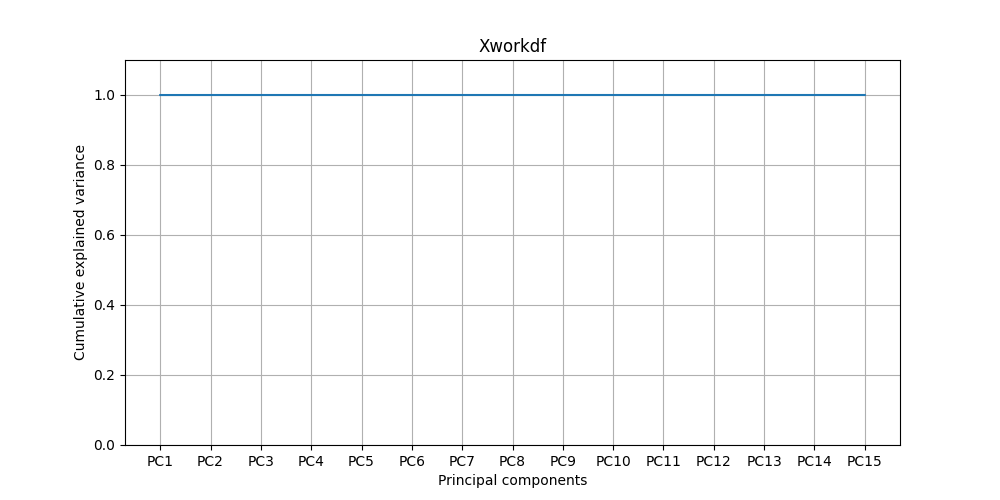

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


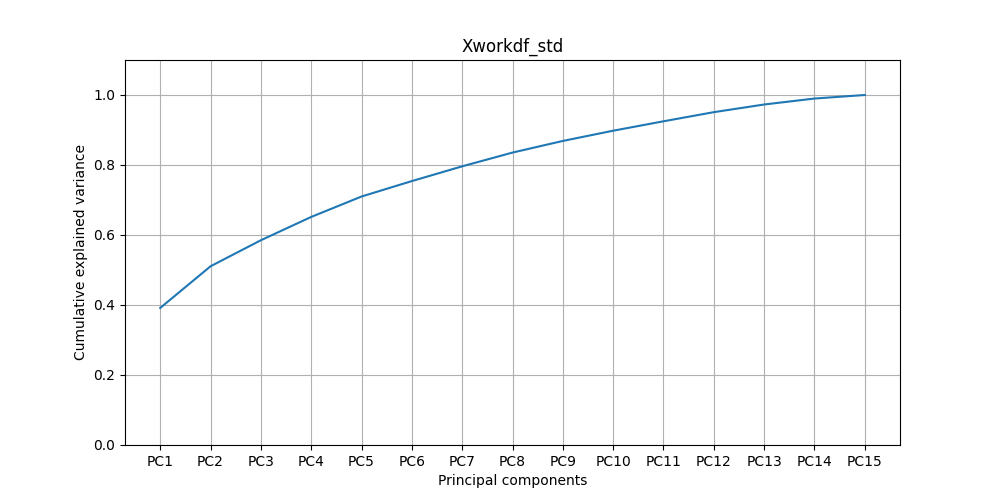

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


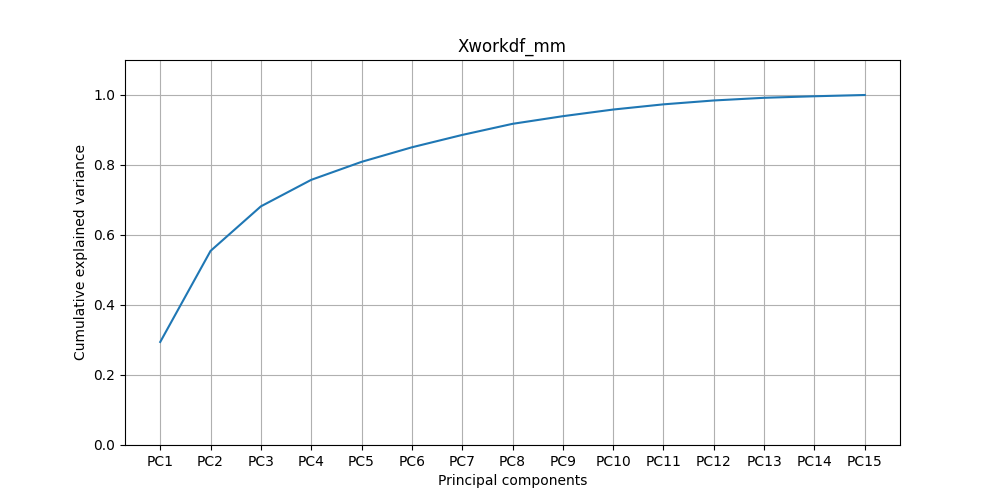

In [26]:
#Apply the “full” PCA1 to the DFs Xworkdf, Xworkdf_std, and Xworkdf_mm
pca_Xworkdf = PCA()
pca_Xworkdf_std = PCA()
pca_Xworkdf_mm = PCA()

pca_Xworkdf.fit(Xworkdf[features].values) 
pca_Xworkdf_std.fit(t_Xworkdf_std)
pca_Xworkdf_mm.fit(t_Xworksf_mm)

#plot the curve of the cumulative explained variance
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca_Xworkdf.explained_variance_ratio_))
plt.title('Xworkdf')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_Xworkdf.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca_Xworkdf.n_features_)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca_Xworkdf_std.explained_variance_ratio_))
plt.title('Xworkdf_std')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_Xworkdf_std.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca_Xworkdf_std.n_features_)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca_Xworkdf_mm.explained_variance_ratio_))
plt.title('Xworkdf_mm')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_Xworkdf_mm.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca_Xworkdf_mm.n_features_)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

## 4 - Dimensionality Reduction and Interpretation of the PCs

### 4.1 - Selection and display of PCs

In [27]:
m_star_std = 1 # m' of Xworkdf_std
m_star_mm = 2 # m' of Xworkdf_mm

m_std = min(m_star_std,5)
m_mm = min(m_star_mm,5)

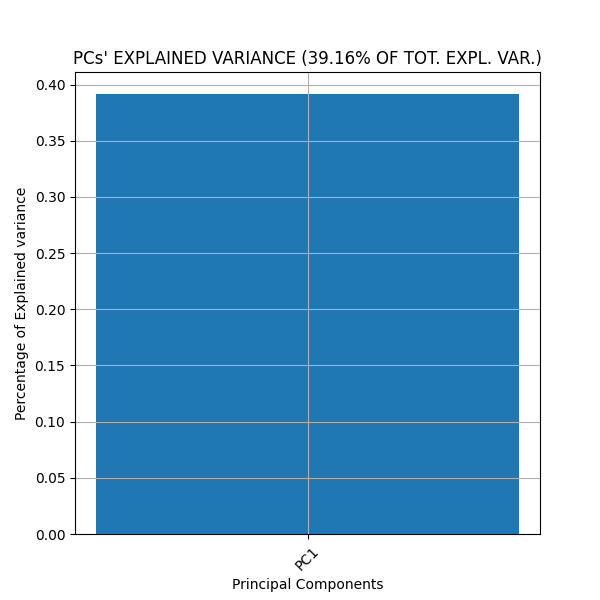

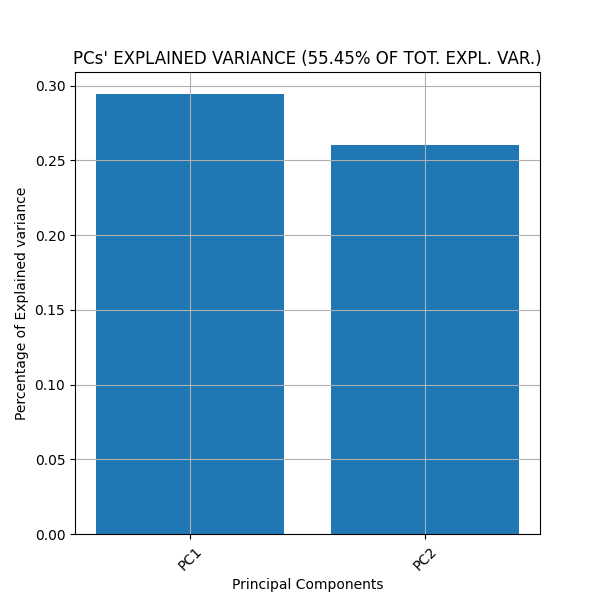

In [28]:
# PCA
pca_std = PCA(n_components = m_std)
pca_mm = PCA(n_components = m_mm)

# Fit the PCA of StandarScaler data
pca_std.fit(t_Xworkdf_std)

# Explained variance rounded to 2 decimals
round_expl_var_ratio_std = np.round(pca_std.explained_variance_ratio_.sum()*100,2)

# Barplots
plt.figure(figsize=(6, 6))
plt.bar(range(1,m_std+1), pca_std.explained_variance_ratio_)
plt.title(f"PCs' EXPLAINED VARIANCE ({round_expl_var_ratio_std}% OF TOT. EXPL. VAR.)")
plt.xticks(ticks=np.arange(1,m_std+1), 
           labels=[f'PC{i}' for i in range(1,m_std+1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained variance')
plt.grid()
plt.show()

# Fit the PCA of MinMaxScaler data
pca_mm.fit(t_Xworksf_mm)

# Explained variance rounded to 2 decimals
round_expl_var_ratio_mm = np.round(pca_mm.explained_variance_ratio_.sum()*100,2)

# Barplots
plt.figure(figsize=(6, 6))
plt.bar(range(1,m_mm+1), pca_mm.explained_variance_ratio_)
plt.title(f"PCs' EXPLAINED VARIANCE ({round_expl_var_ratio_mm}% OF TOT. EXPL. VAR.)")
plt.xticks(ticks=np.arange(1,m_mm+1), 
           labels=[f'PC{i}' for i in range(1,m_mm+1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Percentage of Explained variance')
plt.grid()
plt.show()

### 4.2 - Interpretation of the PCs

#### 4.2.1 - Interpretation of the PCs for StandardScaler data

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


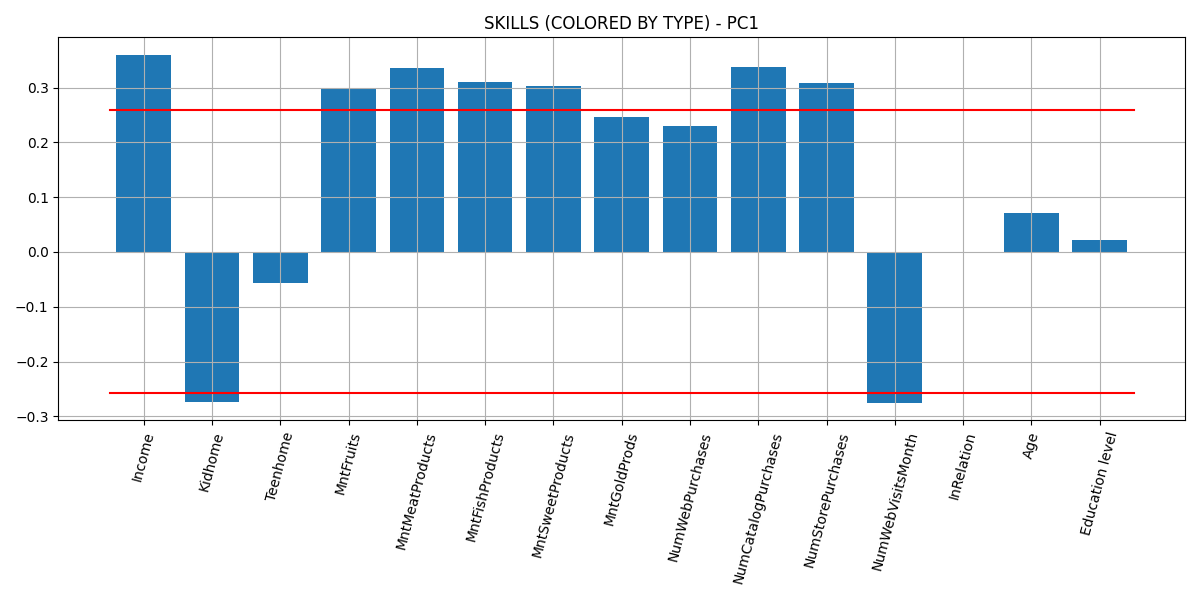


****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Income', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'NumCatalogPurchases', 'NumStorePurchases']

HIGH-VALUED NEGATIVE COMPONENTS: ['Kidhome', 'NumWebVisitsMonth']
*********************************************



In [29]:
# DEFINE EPSILON
eps = np.sqrt(1 / pca_std.n_features_)

# DEFINE THE LIST OF SKILL COLORS W.R.T. THE SKILL TYPES AND THE SKILL CATEGORIES
#skill_colors_type = [skill_types_df.loc[skill_types_df['skill'] == s]['color'].values[0] for s in skill_cols]
#skill_colors_cat = [skill_cats_df.loc[skill_cats_df['skill'] == s]['color'].values[0] for s in skill_cols]

# MAKE A CUSTOM LEGEND
#type_colors_legend = [Line2D([0], [0], color=type_colors[k]) for k in type_colors.keys()]
#cat_colors_legend = [Line2D([0], [0], color=cat_colors[k]) for k in cat_colors.keys()]

# FOR-CYCLE TO GENERALIZE THE PLOT COMMANDS
for ii in range(m_std):
    # MAKE THE BARPLOT WITH SKILL TYPE COLORS
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(pca_std.n_features_), pca_std.components_[ii, :])#,color=skill_colors_type)
    # --- RED LINE DENOTING THE THRESHOLD [-eps, +eps] -----------------
    plt.plot([-0.5, pca_std.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_std.n_features_ - 0.5], [-eps, -eps], 'red')
    # ------------------------------------------------------------------
    plt.xticks(ticks=np.arange(pca_std.n_features_),
               labels= features,
               rotation=75)
    plt.title(f'SKILLS (COLORED BY TYPE) - PC{ii + 1}')
    #plt.legend(type_colors_legend, [k for k in type_colors.keys()])
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # THE SELECTION OF THE SKILLS WITH CONTRIBUTE GREATER THAN THE THRESHOLD
    ind_great_pos_PCii = np.argwhere(pca_std.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_std.components_[ii, :] <= -eps).flatten()
    
    great_pos_PCii = [features[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [features[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')

In [30]:
pc_names_std = ['Kidhome & M_Visit (-) vs Income & P_Mnt & P_Type (+)']

#### 4.2.1 - Interpretation of the PCs for MinMaxScaler data

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


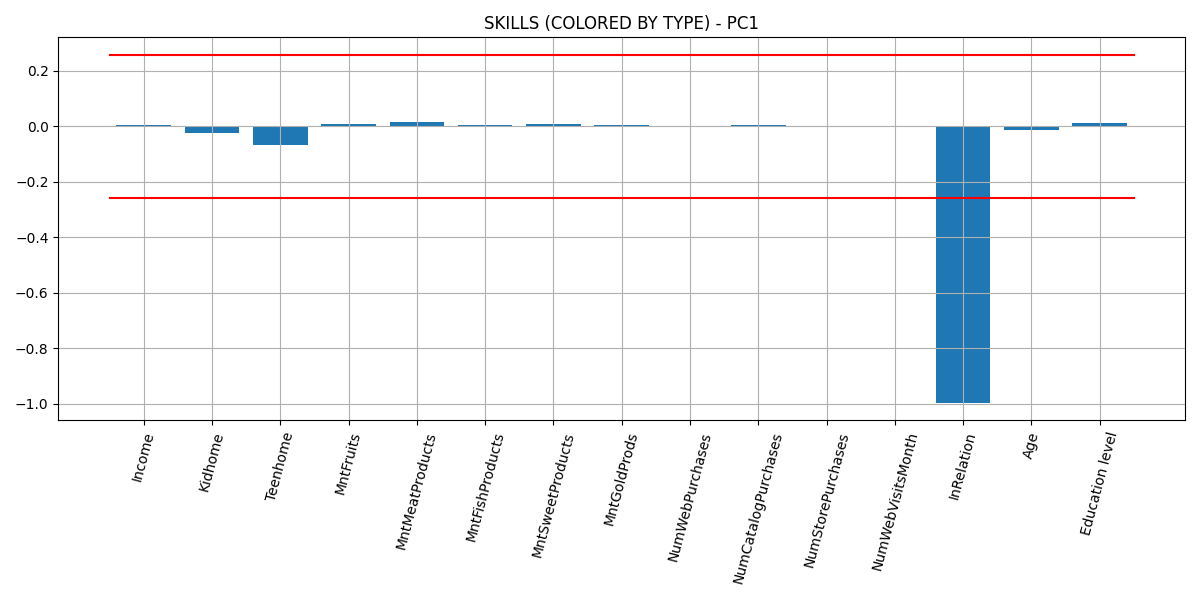

/Users/tommasomazzarini/Documents/venvs/venvCLA/lib/python3.12/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)



****************** PC1 **********************
HIGH-VALUED POSITIVE COMPONENTS: []

HIGH-VALUED NEGATIVE COMPONENTS: ['InRelation']
*********************************************



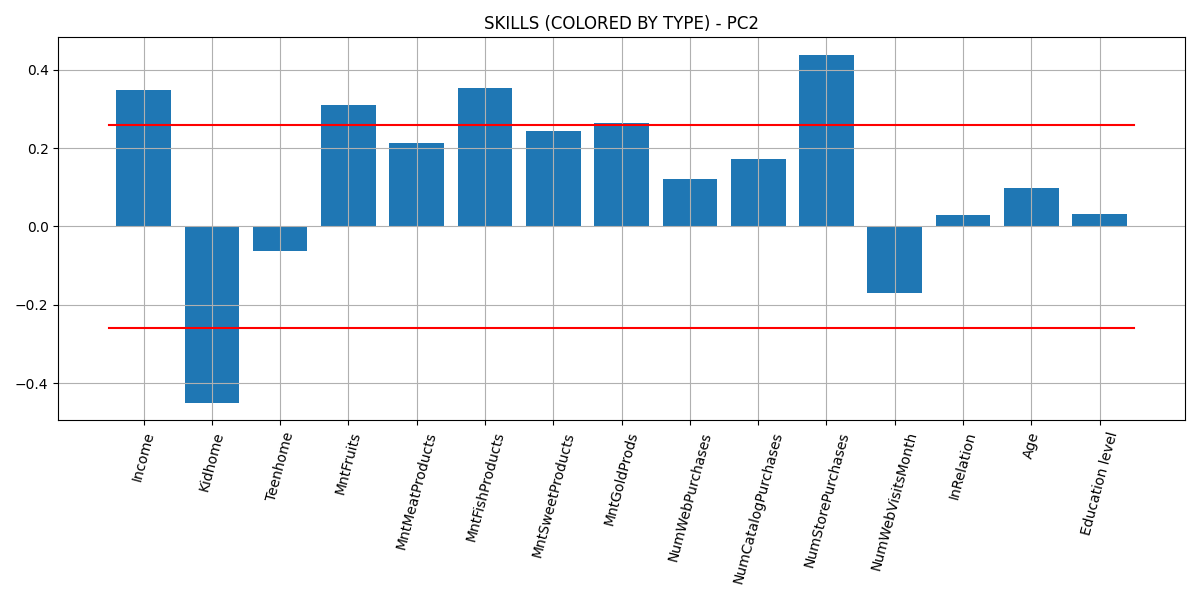


****************** PC2 **********************
HIGH-VALUED POSITIVE COMPONENTS: ['Income', 'MntFruits', 'MntFishProducts', 'MntGoldProds', 'NumStorePurchases']

HIGH-VALUED NEGATIVE COMPONENTS: ['Kidhome']
*********************************************



In [31]:
# DEFINE EPSILON
eps = np.sqrt(1 / pca_mm.n_features_)

# DEFINE THE LIST OF SKILL COLORS W.R.T. THE SKILL TYPES AND THE SKILL CATEGORIES
#skill_colors_type = [skill_types_df.loc[skill_types_df['skill'] == s]['color'].values[0] for s in skill_cols]
#skill_colors_cat = [skill_cats_df.loc[skill_cats_df['skill'] == s]['color'].values[0] for s in skill_cols]

# MAKE A CUSTOM LEGEND
#type_colors_legend = [Line2D([0], [0], color=type_colors[k]) for k in type_colors.keys()]
#cat_colors_legend = [Line2D([0], [0], color=cat_colors[k]) for k in cat_colors.keys()]

# FOR-CYCLE TO GENERALIZE THE PLOT COMMANDS
for ii in range(m_mm):
    # MAKE THE BARPLOT WITH SKILL TYPE COLORS
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(pca_mm.n_features_), pca_mm.components_[ii, :])#,color=skill_colors_type)
    # --- RED LINE DENOTING THE THRESHOLD [-eps, +eps] -----------------
    plt.plot([-0.5, pca_mm.n_features_ - 0.5], [eps, eps], 'red')
    plt.plot([-0.5, pca_mm.n_features_ - 0.5], [-eps, -eps], 'red')
    # ------------------------------------------------------------------
    plt.xticks(ticks=np.arange(pca_mm.n_features_),
               labels= features,
               rotation=75)
    plt.title(f'SKILLS (COLORED BY TYPE) - PC{ii + 1}')
    #plt.legend(type_colors_legend, [k for k in type_colors.keys()])
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # THE SELECTION OF THE SKILLS WITH CONTRIBUTE GREATER THAN THE THRESHOLD
    ind_great_pos_PCii = np.argwhere(pca_mm.components_[ii, :] >= eps).flatten()
    ind_great_neg_PCii = np.argwhere(pca_mm.components_[ii, :] <= -eps).flatten()
    
    great_pos_PCii = [features[i] for i in ind_great_pos_PCii]
    great_neg_PCii = [features[i] for i in ind_great_neg_PCii]
    
    print('')
    print(f'****************** PC{ii+1} **********************')
    print(f'HIGH-VALUED POSITIVE COMPONENTS: {great_pos_PCii}')
    print('')
    print(f'HIGH-VALUED NEGATIVE COMPONENTS: {great_neg_PCii}')
    print('*********************************************')
    print('')

In [32]:
pc_names_mm = ['Relation (-)',
               'Kidhome (-) Vs P_Mnt & P_Store(+)',
               ]

### 4.3 - Score graphs

#### 4.3.1 - Score graph for StandardScaler data

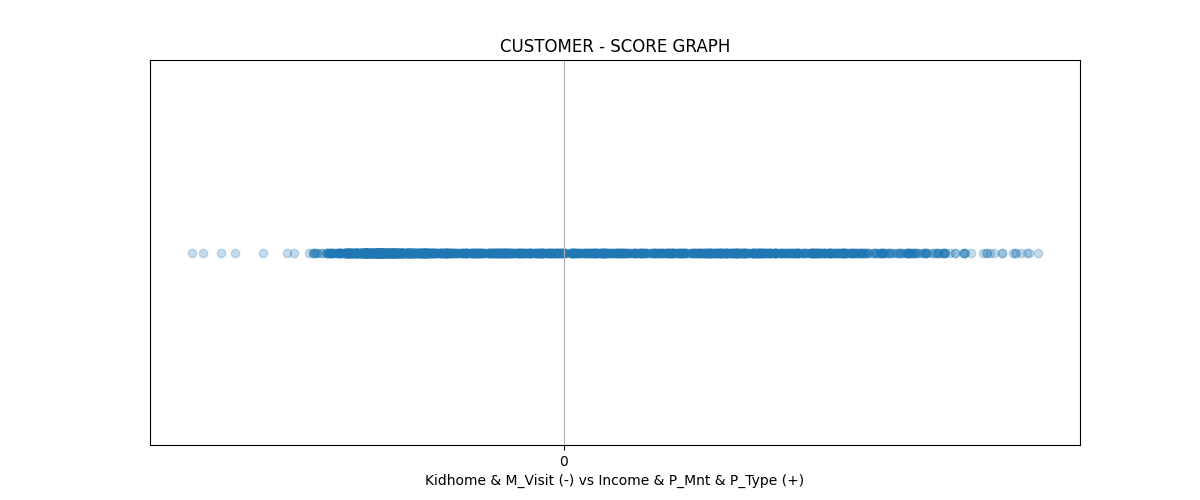

In [33]:
# PCA transform 
Yworkdf_std = pca_std.transform(t_Xworkdf_std)

# Score graph
sg = plt.figure(figsize=(12, 5))
as_sg = sg.add_subplot(111)

as_sg.scatter(Yworkdf_std[:, 0], np.zeros_like(Yworkdf_std[:, 0]), alpha=0.25)  

plt.title('CUSTOMER - SCORE GRAPH')
as_sg.set_xlabel(pc_names_std[0])
as_sg.set_yticks([])
as_sg.set_xticks([0])
plt.grid()
plt.show()

#### 4.3.2 - Score graph for MinMaxScaler data

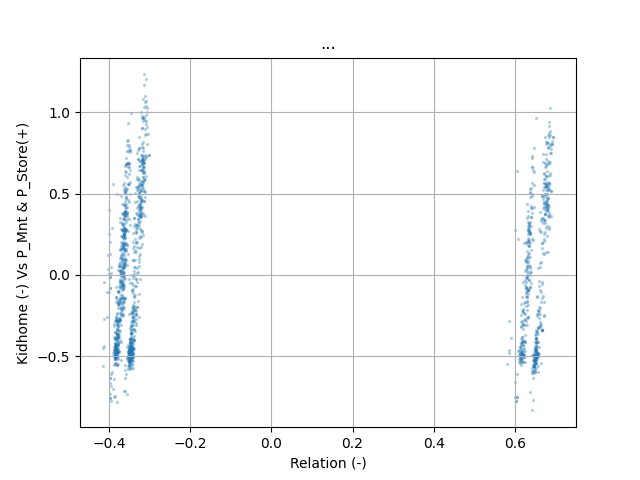

In [34]:
# PCA transform
Yworkdf_mm = pca_mm.transform(t_Xworksf_mm)

# Score graph
plt.figure()
plt.scatter(Yworkdf_mm[:, 0], Yworkdf_mm[:, 1], s=2, alpha=0.25)
plt.title('...')
plt.xlabel(pc_names_mm[0])
plt.ylabel(pc_names_mm[1])
#plt.legend(genpos_colors_legend, [k for k in genpos_colors.keys()])
plt.grid()
plt.show()

### 4.4 - More accurate score graphs

### 4.5 - Analysis and comment

## 5 - K-Means

In [134]:
km_list_std = []
silcoeff_list_std = []
k_list_std = list(range(3, 11))

# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
for i in range(len(k_list_std)):
    print(f'****************** START k-MEANS WITH k={k_list_std[i]} ******************')
    print('Computing...')
    km_list_std.append(KMeans(n_clusters=k_list_std[i], n_init=3, random_state=random_state))
    km_std = km_list_std[i]
    km_std.fit(Yworkdf_std)
    silcoeff_list_std.append(silhouette_score(Yworkdf_std,km_std.labels_))
    print(f'****************** END k-MEANS WITH k={k_list_std[i]} ******************')
    print('')

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_std = np.argmax(silcoeff_list_std)
k_std = k_list_std[i_best_std]
km_std = km_list_std[i_best_std]

# VISUALIZE THE RESULT
print('')
print('')
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE: {np.max(silcoeff_list_std)} --> k = {k_std}') 
print('**************************************************************')

****************** START k-MEANS WITH k=3 ******************
Computing...
****************** END k-MEANS WITH k=3 ******************

****************** START k-MEANS WITH k=4 ******************
Computing...
****************** END k-MEANS WITH k=4 ******************

****************** START k-MEANS WITH k=5 ******************
Computing...
****************** END k-MEANS WITH k=5 ******************

****************** START k-MEANS WITH k=6 ******************
Computing...
****************** END k-MEANS WITH k=6 ******************

****************** START k-MEANS WITH k=7 ******************
Computing...
****************** END k-MEANS WITH k=7 ******************

****************** START k-MEANS WITH k=8 ******************
Computing...
****************** END k-MEANS WITH k=8 ******************

****************** START k-MEANS WITH k=9 ******************
Computing...
****************** END k-MEANS WITH k=9 ******************

****************** START k-MEANS WITH k=10 ******************


In [136]:
km_list_mm = []
silcoeff_list_mm = []
k_list_mm = list(range(3, 11))

# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
for i in range(len(k_list_mm)):
    print(f'****************** START k-MEANS WITH k={k_list_mm[i]} ******************')
    print('Computing...')
    km_list_mm.append(KMeans(n_clusters=k_list_mm[i], n_init=3, random_state=random_state))
    km_mm = km_list_mm[i]
    km_mm.fit(Yworkdf_mm)
    silcoeff_list_mm.append(silhouette_score(Yworkdf_mm,km_mm.labels_))
    print(f'****************** END k-MEANS WITH k={k_list_mm[i]} ******************')
    print('')

# FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
i_best_mm = np.argmax(silcoeff_list_mm)
k_mm = k_list_mm[i_best_std]
km_mm = km_list_mm[i_best_std]

# VISUALIZE THE RESULT
print('')
print('')
print('****************** RESULTS OF THE SEARCH... ******************')
print(f'BEST SILHOUETTE SCORE: {np.max(silcoeff_list_mm)} --> k = {k_mm}') 
print('**************************************************************')

****************** START k-MEANS WITH k=3 ******************
Computing...
****************** END k-MEANS WITH k=3 ******************

****************** START k-MEANS WITH k=4 ******************
Computing...
****************** END k-MEANS WITH k=4 ******************

****************** START k-MEANS WITH k=5 ******************
Computing...
****************** END k-MEANS WITH k=5 ******************

****************** START k-MEANS WITH k=6 ******************
Computing...
****************** END k-MEANS WITH k=6 ******************

****************** START k-MEANS WITH k=7 ******************
Computing...
****************** END k-MEANS WITH k=7 ******************

****************** START k-MEANS WITH k=8 ******************
Computing...
****************** END k-MEANS WITH k=8 ******************

****************** START k-MEANS WITH k=9 ******************
Computing...
****************** END k-MEANS WITH k=9 ******************

****************** START k-MEANS WITH k=10 ******************


## 6 - Clusters and Centroid Interpretation and Visualization

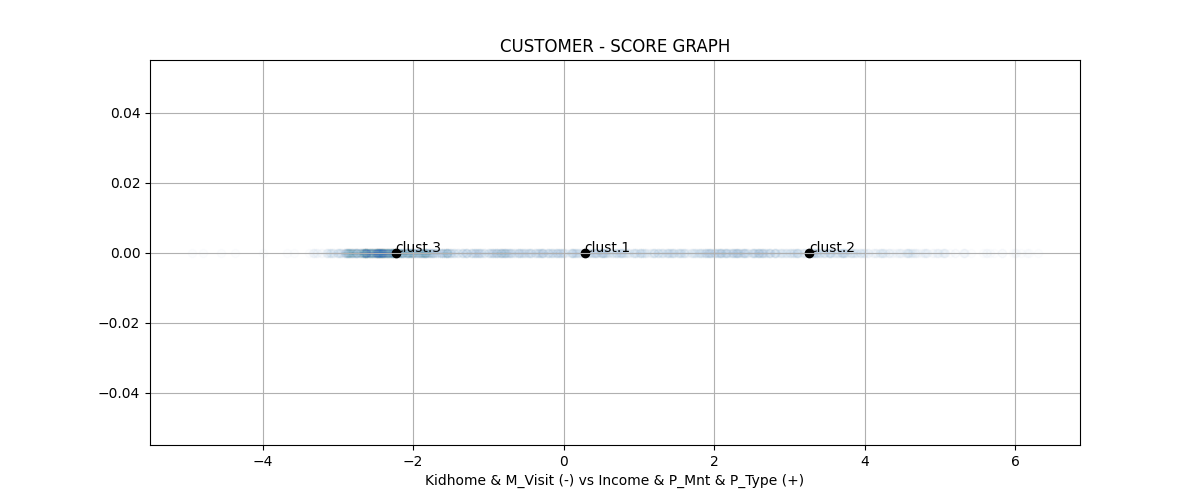

In [139]:
# Score graph with centroids for StandardScaler data
sg_km = plt.figure(figsize=(12, 5))
ax_sg_km = sg_km.add_subplot(111)
ax_sg_km.scatter(Yworkdf_std[:, 0], np.zeros_like(Yworkdf_std[:, 0]), alpha=0.01)  
ax_sg_km.scatter(km_std.cluster_centers_[:,0], np.zeros_like(km_std.cluster_centers_[:,0]), c='black')
for kk in range(k_std):
    ax_sg_km.text(km_std.cluster_centers_[kk, 0], np.zeros_like(km_std.cluster_centers_[kk, 0]), f'clust.{kk+1}')
plt.title('CUSTOMER - SCORE GRAPH')
ax_sg_km.set_xlabel(pc_names_std[0])
#plt.legend(genpos_colors_legend, [k for k in genpos_colors.keys()])
plt.grid()
plt.show()

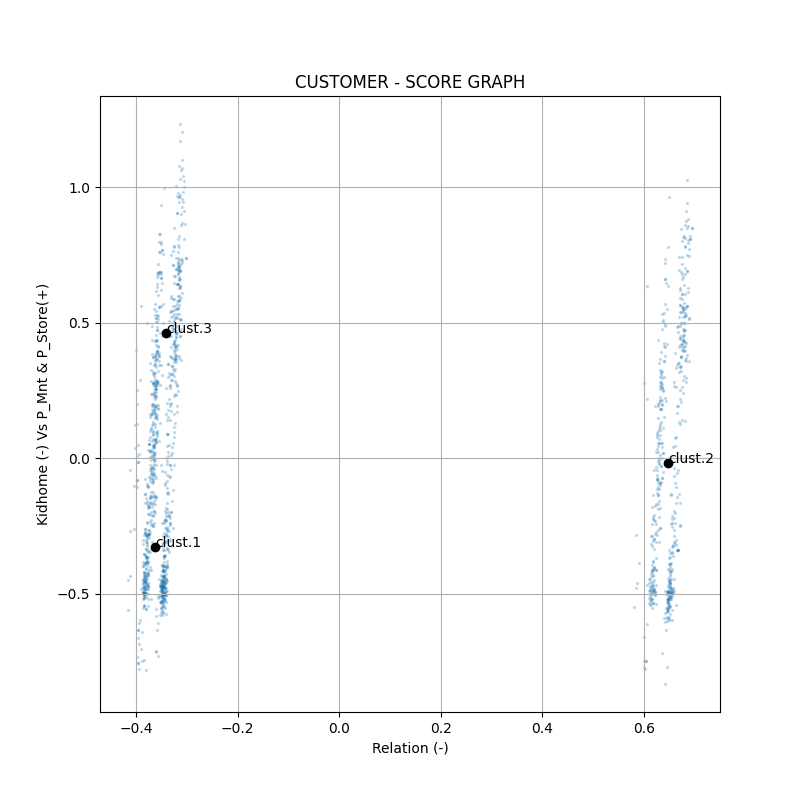

In [140]:
# Score graph with centroids for MinMaxScaler data
sg_km = plt.figure(figsize=(8, 8))
ax_sg_km = sg_km.add_subplot(111)
ax_sg_km.scatter(Yworkdf_mm[:, 0], Yworkdf_mm[:, 1], s=2,alpha=0.2)
ax_sg_km.scatter(km_mm.cluster_centers_[:,0], km_mm.cluster_centers_[:,1], c='black')
for kk in range(k_mm):
    ax_sg_km.text(km_mm.cluster_centers_[kk, 0], km_mm.cluster_centers_[kk, 1], f'clust.{kk+1}')
plt.title('CUSTOMER - SCORE GRAPH')
ax_sg_km.set_xlabel(pc_names_mm[0])
ax_sg_km.set_ylabel(pc_names_mm[1])
#plt.legend(genpos_colors_legend, [k for k in genpos_colors.keys()])
plt.grid()
plt.show()

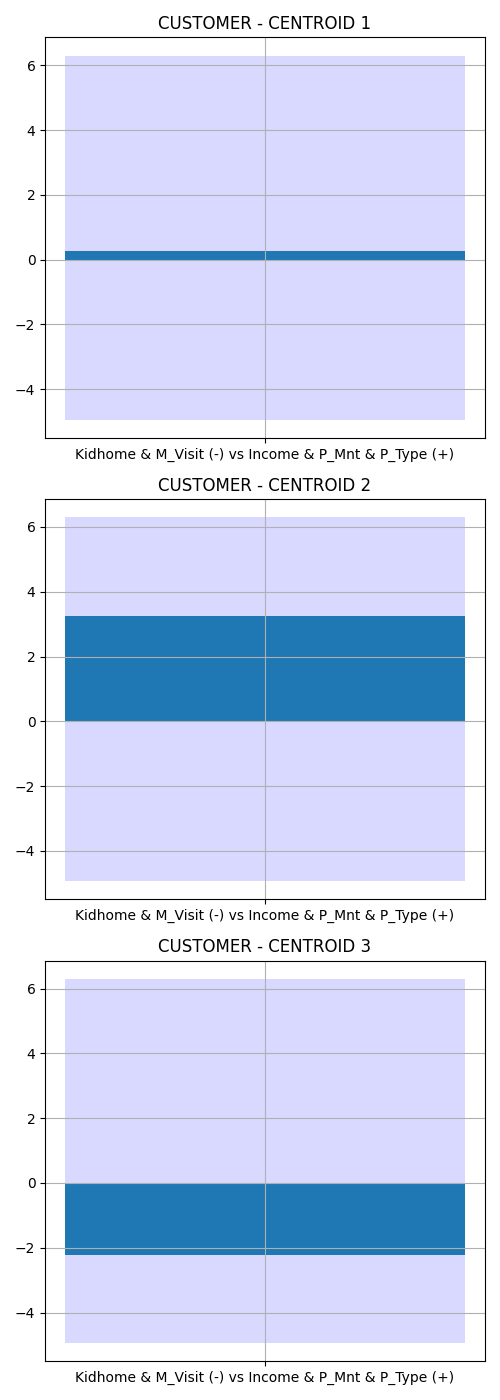

In [142]:
# COMPUTE THE MAX/MIN VALUES IN THE PC-SPACE
maxs_y = Yworkdf_std.max(axis=0) 
mins_y = Yworkdf_std.min(axis=0) 

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids, ax_centroids = plt.subplots(3,1, figsize=(5, 14))
for ii in range(k_std):
    ax_centroids[ii].bar(np.arange(km_std.cluster_centers_.shape[1]), maxs_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km_std.cluster_centers_.shape[1]), mins_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km_std.cluster_centers_.shape[1]), km_std.cluster_centers_[ii,:])
    ax_centroids[ii].set_xticks(ticks=np.arange(km_std.cluster_centers_.shape[1]))
    ax_centroids[ii].set_xticklabels(labels=pc_names_std)
    ax_centroids[ii].grid(visible=True, which='both')
    plt.tight_layout()
    ax_centroids[ii].set_title(f'CUSTOMER - CENTROID {ii+1}')

In [143]:
cluster_names_std = ['Other',
                     'Premium Customer',
                     'Active Family Customer',
                     ]

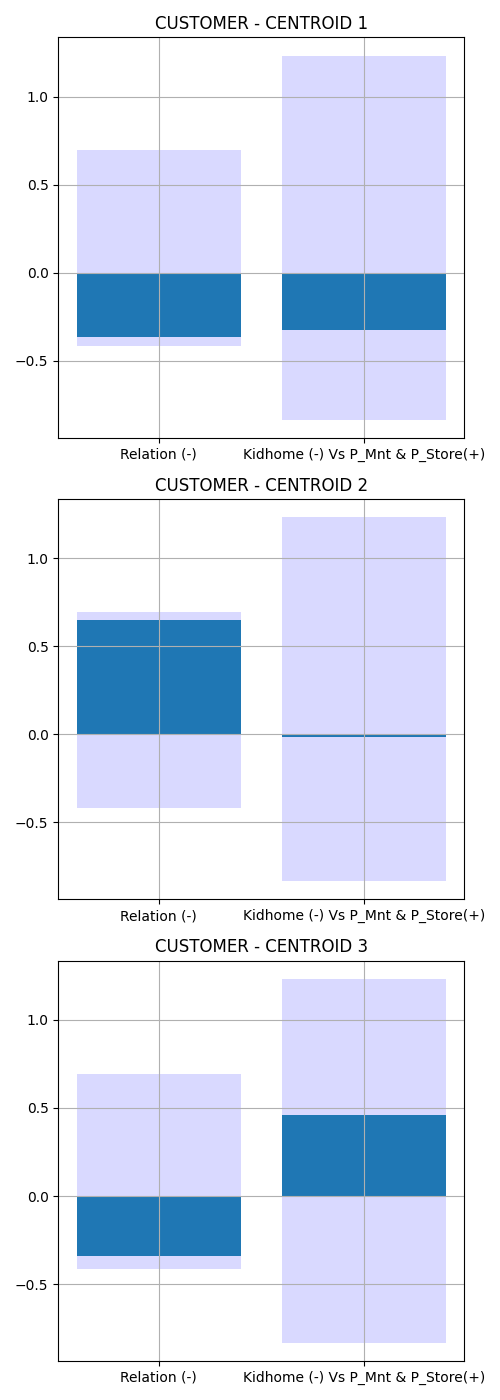

In [144]:
# COMPUTE THE MAX/MIN VALUES IN THE PC-SPACE
maxs_y = Yworkdf_mm.max(axis=0) 
mins_y = Yworkdf_mm.min(axis=0) 

# MAKE THE BARPLOTS OF THE CENTROIDS
fig_centroids, ax_centroids = plt.subplots(3,1, figsize=(5, 14))
for ii in range(k_mm):
    ax_centroids[ii].bar(np.arange(km_mm.cluster_centers_.shape[1]), maxs_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km_mm.cluster_centers_.shape[1]), mins_y, color='blue', alpha=0.15)
    ax_centroids[ii].bar(np.arange(km_mm.cluster_centers_.shape[1]), km_mm.cluster_centers_[ii,:])
    ax_centroids[ii].set_xticks(ticks=np.arange(km_mm.cluster_centers_.shape[1]))
    ax_centroids[ii].set_xticklabels(labels=pc_names_mm)
    ax_centroids[ii].grid(visible=True, which='both')
    plt.tight_layout()
    ax_centroids[ii].set_title(f'CUSTOMER - CENTROID {ii+1}')

In [102]:
cluster_names_mm = ['Family Customer',
                    'Single Customer',
                    'Active Customer',
                    ]

## 7 - Clusters and Centroid Evaluation
- For both the DFs, perform an internal and an external evaluation of the clusterings obtained
  - Measure the silhouette scores of the clusters (internal evaluation);
  - perform an external evaluation of the clusters analyzing and plotting the distribution of the labels (view lesson 22/12/23)
  - Comment the results. Compare the results obtained from Xworkdf std and Xworkdf mm and comment them

In [145]:
silscores = silhouette_samples(Yworkdf_std, km_std.labels_)
cluster_silscores = [np.mean (silscores [km_std.labels_ == kk]) for kk in range (k_std) ]
display(pd.DataFrame(np.array(cluster_silscores + [np.max(silcoeff_list_std)]), index=cluster_names_std + ['Global'], columns=['Sil. Score' ]))

,Sil. Score
Other,0.505328
Premium Customer,0.570182
Active Family Customer,0.725252
Global,0.621639


In [146]:
silscores = silhouette_samples(Yworkdf_mm, km_mm.labels_)
cluster_silscores = [np.mean (silscores [km_mm.labels_ == kk]) for kk in range (k_mm) ]
display(pd.DataFrame(np.array(cluster_silscores + [np.max(silcoeff_list_mm)]), index=cluster_names_mm + ['Global'], columns=['Sil. Score' ]))

,Sil. Score
Family Customer,0.676575
Single Customer,0.503973
Active Customer,0.605146
Global,0.656349


In [ ]:
#EXTERNAL EVALUATION ????